In [30]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import pickle
import seaborn as sns

from keras.layers import (
    Conv1D,
    Dense,
    Embedding,
    GlobalMaxPooling1D,
    TextVectorization,
)
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from string import digits, punctuation
from tqdm import tqdm
from unidecode import unidecode

nltk.download("stopwords")
nltk.download('rslp')
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\T-GAMER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\T-GAMER\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


### Carregando dados

Foram carregados reviews de Smart TVs e Smartphones do Mercado Livre

In [2]:
df_reviews = pd.read_csv("data/product_reviews.csv")

In [3]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74226 entries, 0 to 74225
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   product_id          74226 non-null  object
 1   product_name        74226 non-null  object
 2   product_brand       74226 non-null  object
 3   product_line        74226 non-null  object
 4   review_date         74226 non-null  object
 5   review_text         74226 non-null  object
 6   review_rate         74226 non-null  int64 
 7   review_likes        74226 non-null  int64 
 8   review_dislikes     74226 non-null  int64 
 9   review_relevance    74226 non-null  int64 
 10  client_buying_date  74226 non-null  object
 11  product_type        74226 non-null  object
dtypes: int64(4), object(8)
memory usage: 6.8+ MB


### Transformando dados

Foi aplicada a mediana da quantidade de palavras por registros de review.

Com base nisso, os reviews que possuíam quantidades de palavras abaixo da mediana foram removidos

Também foram removidos reviews com nota 3, pois poderiam impactar negativamente
na geração do modelo, pelo fato de não sabermos como o mesmo classificaria, confundindo a IA

In [4]:
review_median = int(df_reviews["review_text"].str.split().apply(len).median())
df_reviews = df_reviews[df_reviews["review_text"].str.split().apply(len) >= review_median]
df_reviews.drop(df_reviews[df_reviews["review_rate"] == 3].index, inplace=True)

df_reviews.reset_index(drop=True, inplace=True)

Foi definida a classe de cada registro. Para isso, utilizou-se o seguinte critério:
- Reviews com notas 1 e 2 foram classificados como ruins
- Reviews com notas 4 e 5 foram classificados como bons

Também foram removidos do modelo alguns campos, pois não seriam utilizados

In [5]:
df_reviews["class"] = df_reviews["review_rate"].apply(
    lambda item: 1 if item > 3 else 0
)

df_reviews.drop(
    [
        "product_id",
        "product_name",
        "product_brand",
        "product_line",
        "review_date",
        "review_rate",
        "review_likes",
        "review_dislikes",
        "review_relevance",
        "client_buying_date",
        "product_type",
    ],
    axis=1,
    inplace=True,
)

df_reviews.head()

,review_text,class
0,Boa Tv Ate agora gostei so este sistema roku q...,1
1,Maravilhosa Apaixonada serio tô amando essa t...,1
2,Audio e imagem surpreendentes Estou adorando ...,1
3,Ótimo produto e Melhor qualidade!! Ótimaa qual...,1
4,"Superou minhas expectativas Gostei bastante, s...",1


### Tratando texto

Para tratar o texto, foram realizados os seguintes procedimentos:
- Remoção de pontuação e dígitos
- Conversão de todo o texto para minúsculo
- Remoção de quebras de linha
- Remoção de stop words
   - Stop words são palavras que são consideradas irrelevantes para a geração do modelo, portanto podem ser removidas
- [Stemização](https://pt.wikipedia.org/wiki/Stemiza%C3%A7%C3%A3o#:~:text=Em%20morfologia%20lingu%C3%ADstica%20e%20recupera%C3%A7%C3%A3o,uma%20forma%20da%20palavra%20escrita.) das palavras
    - Redução da palavra à sua base
    - Algoritmo utilizado: [RSLP](https://www.inf.ufrgs.br/~viviane/rslp/index.htm)
- Remoção de acentuação

In [6]:
chars_to_remove = punctuation + digits

stemmer = RSLPStemmer()
stop_words = stopwords.words("portuguese")

def text_formatter(text: str):
    table = str.maketrans(chars_to_remove, (" " * len(chars_to_remove)))
    formatted_text = text.lower().replace("\n", " ").translate(table)
    
    formatted_text = " ".join(
        [
            stemmer.stem(word)
            for word
            in formatted_text.split(" ")
            if word
            and word not in stop_words
        ]
    )
    formatted_text = unidecode(formatted_text)
    
    return formatted_text

print("Texto original:")
text = df_reviews["review_text"][0]
print(text)

print("\nTexto formatado:")
formatted_text = text_formatter(text)
print(formatted_text)

Texto original:
Boa Tv Ate agora gostei so este sistema roku que e meio chato.

Texto formatado:
boa tv ate agor gost so sistem roku mei chat


Aplicando tratativa de texto para todos os registros restantes

In [7]:
df_reviews["clean_text"] = df_reviews["review_text"].progress_apply(
    lambda item: text_formatter(item)
)

100%|██████████████████████████████████████████████████████████████████████████| 36362/36362 [00:13<00:00, 2656.24it/s]


In [8]:
df_reviews

,review_text,class,clean_text
0,Boa Tv Ate agora gostei so este sistema roku q...,1,boa tv ate agor gost so sistem roku mei chat
1,Maravilhosa Apaixonada serio tô amando essa t...,1,maravilh apaixon seri to am tv sup satisfeit t...
2,Audio e imagem surpreendentes Estou adorando ...,1,audi imag surpreend ador tv tod app assin ja a...
3,Ótimo produto e Melhor qualidade!! Ótimaa qual...,1,otim produt melhor qual otima qual parabem sup...
4,"Superou minhas expectativas Gostei bastante, s...",1,super expect gost bast super expect fic perfei...
...,...,...,...
36357,"Enganação Aparelho usado, com a tela trincada ...",0,engan aparelh us tel trinc arranho later saud ...
36358,Muito ruim Sofri uma tentativa de golpe e a pe...,0,ruim sofr tent golp pesso vincul ped cont dess...
36359,Produto com defeito. Não segura carga. Produto...,0,produt defeit segur carg produt segur carg car...
36360,"Custo alto, mas o investimento vale a pena! Pr...",1,cust alt invest val pen produt impeca val val ...


### Balanceamento de classes

Para que se obtenha melhores resultados ao gerar o modelo, é necessário que as classes estejam balanceadas.

Desse modo, optamos por gerar um dataset contendo a mesma quantidade de reviews positivos e reviews negativos

In [9]:
df = df_reviews.copy()

df.drop("review_text", axis=1, inplace=True)
df = df[["clean_text", "class"]]

In [10]:
df["class"].value_counts()

1    32398
0     3964
Name: class, dtype: int64

Utilizando o `value_counts` verifica-se a diferença entre a quantidade de classes positivas (1) e classes negativas (0). Para balancear, foram utilizados alguns critérios:

- Inicialmente foram gerados dois datasets, um contendo apenas reviews positivos e outro contendo apenas reviews negativos
- Então foi gerada a média da quantidade de palavras em todos os reviews negativos
- Tendo esse número, foram removidos todos os registros positivos que tinham quantidade de palavras abaixo desta média
- Como ainda sobraram mais registros positivos que negativos, estes foram removidos aleatoriamente até chegar no mesmo valor de números negativos
- Por fim, os dois datasets foram concatenados e o dataset gerado foi salvo num CSV

In [11]:
negative_reviews = df[df["class"] == 0]
positive_reviews = df[df["class"] == 1]

negative_reviews.reset_index(drop=True, inplace=True)
positive_reviews.reset_index(drop=True, inplace=True)

negative_reviews_mean = df[df["class"] == 0]["clean_text"].str.split().apply(len).mean()
print(negative_reviews_mean)

positive_reviews = positive_reviews[positive_reviews["clean_text"].str.split().apply(len) > negative_reviews_mean]
positive_reviews = positive_reviews.sample(n=len(negative_reviews))
positive_reviews.reset_index(drop=True, inplace=True)

df = pd.concat([positive_reviews, negative_reviews])
df.reset_index(drop=True, inplace=True)

18.02648839556004


In [12]:
df["class"].value_counts()

1    3964
0    3964
Name: class, dtype: int64

In [13]:
# df.to_csv("./data/balanced_reviews.csv", index=False)

### Separando em treino e teste

In [14]:
df_result = pd.read_csv("./data/balanced_reviews.csv")
df_result.columns = ["review_text", "class"]

In [15]:
X = df_result["review_text"]
y = df_result["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=5,
)

print(
    f"""
    Shapes:
    X_train: {len(X_train)}
    y_train: {len(y_train)}
    X_test: {len(X_test)}
    y_test: {len(y_test)}
    """
)


    Shapes:
    X_train: 5946
    y_train: 5946
    X_test: 1982
    y_test: 1982
    


### Vetorização

Inicialmente, utiliza-se o `Tokenizer` do Keras para listar todas as palavras existentes no dataset, e então, estimarmos o tamanho do vocabulário.

In [16]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print(word_index)

vocab_size = len(word_index)

{'compr': 1, 'tv': 2, 'otim': 3, 'celul': 4, 'bom': 5, 'produt': 6, 'excel': 7, 'aparelh': 8, 'boa': 9, 'ruim': 10, 'pra': 11, 'bat': 12, 'recom': 13, 'cust': 14, 'tel': 15, 'uso': 16, 'benefici': 17, 'imag': 18, 'dia': 19, 'qual': 20, 'cam': 21, 'melhor': 22, 'problem': 23, 'bem': 24, 'gost': 25, 'tod': 26, 'nao': 27, 'fic': 28, 'som': 29, 'rapid': 30, 'dur': 31, 'outr': 32, 'defeit': 33, 'val': 34, 'nad': 35, 'mes': 36, 'pess': 37, 'vei': 38, 'func': 39, 'pouc': 40, 'carreg': 41, 'pod': 42, 'us': 43, 'prec': 44, 'perfeit': 45, 'tr': 46, 'tud': 47, 'lig': 48, 'sup': 49, 'sistem': 50, 'jog': 51, 'marc': 52, 'aplic': 53, 'app': 54, 'faz': 55, 'poi': 56, 'ter': 57, 'android': 58, 'top': 59, 'control': 60, 'aind': 61, 'ach': 62, 'q': 63, 'vez': 64, 'agor': 65, 'deu': 66, 'funcion': 67, 'algum': 68, 'apresent': 69, 'deix': 70, 'muit': 71, 'atend': 72, 'nov': 73, 'baix': 74, 'porem': 75, 'not': 76, 'menos': 77, 'bonit': 78, 'facil': 79, 'pen': 80, 'precis': 81, 'trav': 82, 'esper': 83, 'sma

Após isso, foi realizada a vetorização dos textos das reviews.

Este procedimento consiste em transformar uma sequência de strings em uma lista de inteiros que representam os índices de cada token, ou seja, cada palavra do vocabulário, ou em uma lista com valores float que representam informações sobre os tokens.

Basicamente, este procedimento de vetorização transforma linguagem natural em um formato compreensível para o modelo.

Na vetorização, foram definidas algumas opções:
- Padronização foi desabilitada, pois os textos já foram padronizados anteriormente
- Modo de saída foi definido como `int`, que retorna um vetor de inteiros, em que cada item do vetor corresponde a uma palavra
    - Como o índice 0 corresponde a espaços vazios no vetor, o número máximo de tokens na vetorização foi definido como o tamanho do vocabulário menos 2, pois é retirado 1 do tamanho do vocabulário por conta dos tokens OOV (out of vocabulary), usados para substituir palavras desconhecidas, e outro por conta do 0
- O vetor de saída da vetorização sempre terá o tamanho 100

Por fim, foi utilizado o `adapt`, para criar um vocabulário a partir das palavras do dataset, determinando a frequência de cada palavra existente

In [17]:
vocab_size

5044

In [18]:
vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=(vocab_size - 2),
    output_mode="int",
    output_sequence_length=100,
)

vectorize_layer.adapt(X_train)

Então, a vetorização foi aplicada aos dados de treino e de teste

In [19]:
X_train_data = vectorize_layer(X_train).numpy()
y_train_data = y_train.astype("int")

X_test_data = vectorize_layer(X_test).numpy()
y_test_data = y_test.astype("int")

In [20]:
X_train_data, X_test_data

(array([[ 120,   71,  352, ...,    0,    0,    0],
        [   3,  642,   24, ...,    0,    0,    0],
        [ 428,  161,  114, ...,    0,    0,    0],
        ...,
        [  28,   26,    3, ...,    0,    0,    0],
        [   5,    8,  302, ...,    0,    0,    0],
        [ 224,   48, 1245, ...,  143,  453,  737]], dtype=int64),
 array([[   8, 2158,  275, ...,    0,    0,    0],
        [  11,    5,   11, ...,    0,    0,    0],
        [ 139,  293, 1404, ...,    0,    0,    0],
        ...,
        [  11,   13,   10, ...,    0,    0,    0],
        [  11,  395,   12, ...,    0,    0,    0],
        [  12,  146,    2, ...,    0,    0,    0]], dtype=int64))

In [21]:
X_train_data[0].shape, X_test_data[0].shape

((100,), (100,))

### Criando modelo

O modelo foi criado utilizando o Keras, utilizando as seguintes camadas:

- **Embedding:**
    - Converte valores inteiros (referentes aos índices de cada palavra, que foi obtido na vetorização) em vetores de tamanho fixo. Esta camada é inicializada com pesos aleatórios e aprende a incorporação (embedding) para todas as palavras do dataset de treino, aprendendo junto com o modelo.
    - Neste caso, foi definida a dimensão de entrada como o tamanho do vocabulário, e a dimensão de saída como um vetor de tamanho 100.
    - Links úteis:
        - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
        - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
        - https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
- **Conv1D:**
    - Camada convolucional de 1 dimensão - usada para texto
    - Cria um kernel de convolução que envolve a camada de entrada (no caso, a Embedding) em uma única dimensão para, deste modo, gerar um vetor de saídas
    - Neste caso, a camada de convolução de 1 dimensão utilizou 128 filtros de saída na convolução, um kernel size de tamanho 5, que seria janela de convolução, e também utilizou a função de ativação relu
    - Links úteis:
        - https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/
        - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
- **GlobalMaxPooling1D:**
    - Retorna um vetor de saída de tamanho fixo para cada registro, buscando o valor máximo na dimensão deste registro.
    - Links úteis:
        - https://keras.io/api/layers/pooling_layers/global_max_pooling1d/
        - https://www.tensorflow.org/text/guide/word_embeddings#create_a_classification_model
- **Dense (100):**
    - Camada oculta com 100 neurônios e função de ativação relu
    - Links úteis:
        - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense#input-shape
- **Dense (1):**
   - Camada de saída com 1 neurônio (valor da saída) e função de ativação sigmoid
   
Para a compilação do modelo foi utilizado o otimizador **Adam**, que implementa o algoritmo Adam para otimização, que consiste em um método de gradiente descendente estocástico baseada na estimativa adaptável de momentos de primeira e segunda ordem.
- Links úteis:
    - https://keras.io/api/optimizers/adam/
    - https://acervolima.com/intuicao-de-adam-otimizador/

Para calcular a perda (loss), foi utilizado ***Binary Crossentropy**, que calcula a entropia cruzada entre classes previstas pelo modelo e classes esperadas.
- Links úteis:
    - https://keras.io/api/losses/probabilistic_losses/

Para executar o módelo, foram utilizadas 20 épocas e um batch size de 10.

In [22]:
model = Sequential()

Embedding

model.add(Embedding(vocab_size, 100))
model.add(Conv1D(filters=128, kernel_size=5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.001)
loss = BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         504400    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 581,529
Trainable params: 581,529
Non-trainable params: 0
__________________________________________________

In [23]:
epochs = 20 #100
batch_size = 10 #len(X_train_data)

history = model.fit(
    X_train_data,
    y_train_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/20
595/595 [==============================] - 6s 10ms/step - loss: 0.2297 - accuracy: 0.9102
Epoch 2/20
595/595 [==============================] - 6s 9ms/step - loss: 0.0701 - accuracy: 0.9751
Epoch 3/20
595/595 [==============================] - 5s 9ms/step - loss: 0.0128 - accuracy: 0.9968
Epoch 4/20
595/595 [==============================] - 5s 9ms/step - loss: 0.0024 - accuracy: 0.9995
Epoch 5/20
595/595 [==============================] - 5s 9ms/step - loss: 5.0661e-04 - accuracy: 1.0000
Epoch 6/20
595/595 [==============================] - 5s 9ms/step - loss: 8.7766e-05 - accuracy: 1.0000
Epoch 7/20
595/595 [==============================] - 5s 9ms/step - loss: 5.1138e-05 - accuracy: 1.0000
Epoch 8/20
595/595 [==============================] - 5s 9ms/step - loss: 3.4347e-05 - accuracy: 1.0000
Epoch 9/20
595/595 [==============================] - 5s 9ms/step - loss: 2.3639e-05 - accuracy: 1.0000
Epoch 10/20
595/595 [==============================] - 5s 9ms/step - loss: 1.56

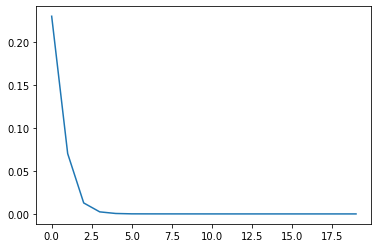

In [24]:
plt.plot(history.history["loss"])
plt.show()

In [25]:
test_results = model.evaluate(X_test_data, y_test_data)
print(f"Accuracy: {test_results[1]:.3f}")

62/62 [==============================] - 0s 3ms/step - loss: 0.3527 - accuracy: 0.9546
Accuracy: 0.955


Por fim, para gerar as métricas resultantes da classificação e a matriz de confusão, os dados de teste foram previstos um a um e, a partir do valor retornado pelo modelo, caso este fosse maior que 0.5, era considerado 1 (review positiva) e, caso fosse menor ou igual a 0.5, era considerado 0 (review negativa)

In [26]:
y_pred = model.predict(X_test_data).squeeze()
y_pred_results = [1 if item > 0.5 else 0 for item in y_pred]

print("\n\n")

print(classification_report(y_pred_results, y_test))

62/62 [==============================] - 0s 3ms/step



              precision    recall  f1-score   support

           0       0.95      0.96      0.95       987
           1       0.96      0.95      0.95       995

    accuracy                           0.95      1982
   macro avg       0.95      0.95      0.95      1982
weighted avg       0.95      0.95      0.95      1982



<Axes: >

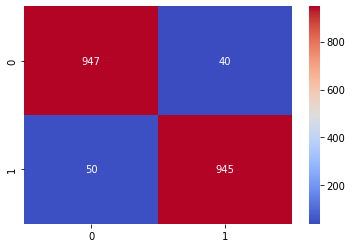

In [27]:
cm = confusion_matrix(y_pred_results, y_test)
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="g")

### Salvando modelo

In [28]:
model.save("./model/conv_review_classifier")

INFO:tensorflow:Assets written to: ./model/conv_review_classifier\assets


INFO:tensorflow:Assets written to: ./model/conv_review_classifier\assets


In [31]:
vectorizer_weights = {
    "config": vectorize_layer.get_config(),
    "weights": vectorize_layer.get_weights(),
}

with open("./model/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer_weights, f)